## Reinforcement Learning - Aoudia and Hoydis
##### Imports

In [64]:
import tensorflow as tf
import keras 
import numpy as np
from keras.layers import Input, Dense, Lambda, ELU, Reshape
from keras.models import Model
from keras.layers.normalization import BatchNormalization 
from keras import backend as K
from keras.layers import GaussianNoise, advanced_activations
from keras.engine.topology import Layer
from keras.legacy import interfaces
from keras.initializers import Zeros as kZeros
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from time import time
import pickle

In [6]:
# # confirm TensorFlow sees the GPU
# from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# # confirm Keras sees the GPU
# from keras import backend
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

In [7]:
# # This is in a seperate box because it isn't running on the 
# # AWS server. 
# from tqdm import tqdm_notebook, tnrange

##### Useful guides
https://hub.packtpub.com/build-reinforcement-learning-agent-in-keras-tutorial/
<br>
https://medium.com/ml-everything/policy-based-reinforcement-learning-with-keras-4996015a0b1
<br>

##### Notes from paper
- Loss function = Cross Entropy
- Normalisation = Average L2 power constraint = 1. $\mathbb{E}\left[\frac{1}{N}\left\Vert x\right\Vert_2^2\right]$ = 1.
- Trained at an SNR of 10dB for AWGN and an SNR of 20dB for RBF channel. $\sigma_{\pi}^2$ = 0.02 at training time.
    - During RL exploration $\mathbf{x_p} = \mathbf{x} + \mathbf{w}$, where each element of $\mathbf{w}$ is i.i.d ~ $\mathcal{N}(0,\sigma_{\pi}^2)$
- M= 256, N=4. N= the number of complex channel uses, so n = 8. Therefore n,k = (8,8)
- AWGN -> 1 hidden layer, size M, ReLu activation function
- Rayleigh -> see diagram.
    - Two layers (Dense(20,tanh)->Dense(2,linear)) calculate an estimate for $\hat{h}$, then we divide the received signal by $\hat{h}$ then have two layers for finding the received signal. Dense(M,ReLu) then Dense(M,Softmax). Then have the select maximum likelihood symbol layer.
- SNR $ = \frac{\mathbb{E}\left[\frac{1}{N}\left\Vert x\right\Vert_2^2\right]}{\sigma^2}$, but because of the normalisation this is $\frac{1}{\sigma^2}$.
- The RBF seems to be slow fading, but I could check for fast fading as well. Rayleigh fading is of the form $\mathbf{r} = \mathbf{s}*\mathbf{h} + \mathbf{n}$ where $\mathbf{h}$ ~ $\mathcal{N}(0,\sigma_m^2)$, $\mathbf{n}$ ~ $\mathcal{N}(0,\sigma_a^2)$. 
    - Slow fading: h stays the same across the whole minibatch
    - Fast fading: h changes every sample
- I'm going to guess that $\sigma_m ~ \frac{1}{3}$. Because this means that 98% of the time it's less than 1. Which sounds alright.
- I could also try Ricean fading and see how the model performs against that.
- Ricean fading would actually be the most general, as then it could learn Rayleigh fading, and it could also learn AWGN just by learning to make $\hat{h}$ every time.

##### Work Log

27/05/2019
- Started researching RBF, think I can implement it in a custom layer.
- Made lots of notes
- Copied over functions from other notebook.

28/05/2019
- Made functions for making the Tx and Rx blocks for the unsupervised learning, however these will likely need to be edited.


29/05/2019
- Got food poisoning the night before and did no work.

31/05/2019
- Got the rbf supervised model fitting, but with no good results. 
- Copied the architecture from the paper exactly, however it was not effective. This involved:
    - Adding layers for complex multiplication and division.
    - Adding layers for seperately finding the $\hat{h}$ as an expert feature.
    - Adding a custom layer that added rbf fast fading 
- Initially I set the $sigma_m$ to 0.33, for the reasons laid out above, but the model wasn't making any progress training. So after some research I found it written online somewhere that it is often set to $\frac{1}{\sqrt{2}}$ to give unity fading gain on average. This seems wrong as you should expect to lose power in the channel. However, upon trying this the model trained vastly more successfully so I may stick with this, or train at a higher SNR if I don't use this.
- Going to try debugging it for a while, then I may try using different numbers of layers and activation functions to try and get the two supervised lines in Figures 6a and 6b from the Aoudia and Hoydis paper. After this I can try and get the reinforcement learned lines giving the same results. 

03/06/2019
- Converting the interim report into the introduction and background sections of the final report. Also writing the abstract.

04/06/2019
- Fixed the average power normalisation
- Continued converting the interim report into the start of a final report.
- Found that the model had very significant gains if I trained it with $sigma_a = 0$, investigating whether this could be an effective way of training the $\hat{h}$ estimation section of the model more quickly so it could then go on to learning the additive noise section later. However this is not how it would be able to work in a normal channel.
    - On this subject it was found that the model hardly learnt anything in an RBF channel at 20db of SNR. So 40db was trialled which was more successful, but still trained extremely slowly. This is how no noise was trielled, which gave extremely fast reduction of validation loss.

##### To do
- Work out why the average power constraint is giving a power per symbol of 0.25.
- Run overnight my best unsupervised AWGN model and check it looks the same as the spuervised line from 6a, plot it the same etc.

### Function Definitions

In [8]:
def most_likely(posterior_probs):
    max_vals = K.max(posterior_probs, axis=1, keepdims=True) 
    max_vals = K.cast(max_vals, 'float32')
    geT = K.greater_equal(posterior_probs, max_vals)
    return K.cast(geT, 'float32')

In [9]:
def get_noise_sigma(Eb_N0_db, Rr=None, Rc=None):
    assert(not((Rr == None)&(Rc == None)))
    if(Rr == None):
        Rr = Rc/2.
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*Rr*Eb_N0))

In [10]:
def get_data_set(M, total_size):
    t0 = time()
    all_one_hot_messages = np.diag(np.ones(M))
    perc_train = 0.75
    perc_valid = 0.1

    ## Making Data Set
    multiple = total_size//M
    diff = total_size - (multiple * M)

    ## Get quotient 
    ## Converted the array into a list because it is significantly
    ## faster
    l = []
    all_one_hot_messages_lst = all_one_hot_messages.tolist()
    for mult in range(multiple):
        for i in range(M):
            l.append([all_one_hot_messages_lst[i]])
    data = np.concatenate(l)

    # Add remainder
    random_inds = np.random.choice(np.arange(M),size=diff, replace=False)
    extra_rows = all_one_hot_messages[random_inds,:]
    data = np.concatenate((data, extra_rows), axis=0)
    np.random.shuffle(data)
    file_path = "./data/data"+str(M)+".npy"
    np.save(file_path, data)
    print(f"Took {time() - t0}s")
    return data, file_path, all_one_hot_messages

In [11]:
class MostLikelySymbol(Layer):
    """Return the most likely symbol from a softmax input in the
    one hot encoded form.

    This layer is only active at test time as otherwise it would
    stop gradient propogation during training. Also it is useful
    to train with a softmax output to encourage a decisive 
    decision and because it means you can assess confidence.

    # Arguments
        None

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    @interfaces.legacy_gaussiannoise_support
    def __init__(self, **kwargs):
        super(MostLikelySymbol, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None):
        def most_likely():
            max_vals = K.max(inputs, axis=1, keepdims=True) 
            max_vals = K.cast(max_vals, 'float32')
            geT = K.greater_equal(inputs, max_vals)
            return K.cast(geT, 'float32')            
        return K.in_train_phase(inputs, most_likely, training=training)

    def get_config(self):
        config = {}
        base_config = super(MostLikelySymbol, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [12]:
class GaussianNoise2(Layer):
    """Apply additive zero-centered Gaussian noise at both traning
    and test time.

    This is useful to mitigate overfitting
    (you could see it as a form of random data augmentation).
    Gaussian Noise (GS) is a natural choice as corruption process
    for real valued inputs.

    Unlike the built in GaussianNoise regularisation layer it is 
    active at both training and test time. 

    # Arguments
        stddev: float, standard deviation of the noise distribution.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    @interfaces.legacy_gaussiannoise_support
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise2, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            return inputs + K.random_normal(shape=K.shape(inputs),
                                            mean=0.,
                                            stddev=self.stddev)
        return K.in_train_phase(noised, noised, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(GaussianNoise2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [13]:
class RayleighBlockFading_fast(Layer):
    """
    Applies Rayleigh Block (fast) Fading to the input data at both 
    training and test time.

    # Arguments
        sigma_m: float, standard deviation of the multiplicative 
        constant noise distribution.
        sigma_a: float, standard deviation of the additive 
        constant noise distribution.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    def __init__(self, sigma_m, sigma_a, **kwargs):
        super(RayleighBlockFading_fast, self).__init__(**kwargs)
        self.supports_masking = True
        self.sigma_m = sigma_m
        self.sigma_a = sigma_a

    def call(self, inputs, training=None):   
        def custom_mult(in_,col_sel,h):
            tmp = K.tf.multiply(col_sel,h)
            tmp_expand = K.expand_dims(tmp,axis=1)
            return K.tf.multiply(in_,tmp_expand)
        def complex_mult(in_,h):
            o1 = K.constant(np.array([1,0]))
            o2 = K.constant(np.array([0,1]))
            h_swap = K.tf.reverse(h,[1])
            in_swap = K.tf.reverse(in_,[2])

            t1 = custom_mult(in_,o1,h)          # real*real
            t2 = custom_mult(in_swap,o1,h_swap) # imaginary*imaginary
            t3 = custom_mult(in_swap,o2,h)      # real*imaginary
            t4 = custom_mult(in_,o2,h_swap)     # imaginary*real

            total1 = K.tf.math.subtract(t1,t2)  # r1*r2-i1*i2
            total2 = K.tf.math.add(t3,t4)       # r1*i2 + i1*r2
            return K.tf.math.add(total1,total2) # r1*r2-i1*i2 + r1*i2 + i1*r2
        def RBF_fade():
            hT = K.random_normal(shape=(K.shape(inputs)[0],K.shape(inputs)[2]),
                                 mean=0.,
                                 stddev=self.sigma_m)
            nT = K.random_normal(shape=K.shape(inputs),
                                 mean=0.,
                                 stddev=self.sigma_a)
            return K.tf.add(complex_mult(inputs,hT),nT)
        return K.in_train_phase(RBF_fade, RBF_fade, training=training)

    def get_config(self):
        config = {'sigma_m': self.sigma_m, 'sigma_a': self.sigma_a}
        base_config = super(RayleighBlockFading_fast, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [14]:
def get_layer_shapes(start, end, num_steps):
    shapes = [start]
    diff = (end-start)/(num_steps-1)
    # Always start with a full dense layer
    for i in range(1,num_steps):
        shapes.append(int(start + i*diff))
    return shapes

In [15]:
def make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                hl_activation_func, \
                                                ol_activation_func, \
                                                num_layers):
    ### Initialising Parameters
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nc = int(round(k/R)) # Number of bit being used to represent
                        # channel symbols being used 
                        # Number of complex channel uses
    Nr = Nc*2 # Number of real channel uses

    ### Defining Layers
    ## TRANSMITTER
    tx_shapes = get_layer_shapes(M, Nr, num_layers)
    input_message = Input(shape=(M,), name="input")
    # Hidden Tx layers
    tx1 = Dense(tx_shapes[0],activation=hl_activation_func, \
                name="tx1")(input_message)
    for i in range(1,num_layers-1):
        tx1 = Dense(tx_shapes[i],activation=hl_activation_func, \
                    name=("tx"+str(i+1)))(tx1)
    # Final layer with a different activation function to capture non
    # linearity
    tx_n = Dense(tx_shapes[-1],activation=ol_activation_func, \
                 name=("tx"+str(num_layers)))(tx1)
    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx_n)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(Nr)), x),
                      output_shape=(Nr,), name="tx_norm_scaled")\
                        (tx_norm)
    
    # Add Noise 
    noise = GaussianNoise2(sigma)(tx_norm_scaled)

    ## RECIEVER
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(noise)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    rx1 = Dense(tx_shapes[-2],activation=ol_activation_func, name="rx1")\
                (noise_flat)
    # Hidden Rx Layers
    if(num_layers >= 3):
        layer_ind = -3
    else:
        layer_ind = -2
    rx_i = Dense(tx_shapes[layer_ind],activation=hl_activation_func, \
                name="rx2")(rx1)
    for i in range(2,num_layers):
        ind = max(0,num_layers - 2 - i)
        rx_i = Dense(tx_shapes[ind],activation=hl_activation_func, \
                    name=("rx"+str(i+1)))(rx_i)
    # Dense layer with softmax activation
    rx_softmax = Dense(tx_shapes[0],activation='softmax', \
                       name="rx_softmax")(rx_i)
    
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)
    
    ###Defining the models
    autoencoder = Model(input_message, rx_softmax)
    ## Model the Tx and Rx seperately as well
    # Model the Tx
    transmitter = Model(input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(input_message, noise)
    channel_symbol = Input(shape=(Nr,))
    # Take the last layer of the autoencoder model
    reciever_layers = autoencoder.layers[-(num_layers+1)](channel_symbol)
    for i in range(num_layers):
        reciever_layers = autoencoder.layers[-(num_layers-i)](reciever_layers)

    # Create a model of the reciever
    reciever = Model(channel_symbol, reciever_layers)
    autoencoder_symbs = Model(input_message,ml_symbs) 
    
    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    return autoencoder, transmitter, reciever,\
            autoencoder_symbs, k, Nc, Nr

In [16]:
def custom_mult(in_,col_sel,h):
    tmp = K.tf.multiply(col_sel,h)
    tmp_expand = K.expand_dims(tmp,axis=1)
    return K.tf.multiply(in_,tmp_expand)

def complex_div(in_lst):
    in_,h = in_lst
    o1 = K.constant(np.array([1,0]))
    o2 = K.constant(np.array([0,1]))
    h_swap = K.tf.reverse(h,[1])
    in_swap = K.tf.reverse(in_,[2])

    t1 = custom_mult(in_,o1,h)          # real*real
    t2 = custom_mult(in_swap,o1,h_swap) # imaginary*imaginary
    t3 = custom_mult(in_swap,o2,h)      # real*imaginary
    t4 = custom_mult(in_,o2,h_swap)     # imaginary*real

    total1 = K.tf.math.add(t1,t2)        # xr*hr-xi*hi
    total2 = K.tf.math.subtract(t4,t3)   # xr*hi-xi*hr
    total = K.tf.math.add(total1,total2) # xr*hr+xi*hi + xr*hi-xi*hr

    scale_factor = K.sum(K.tf.math.square(h), axis=1) # hr^2 + hi^2
    scale_factor_expanded_twice = K.expand_dims(K.expand_dims(scale_factor, axis=1), axis=2)
    return K.tf.math.divide(total,scale_factor_expanded_twice) 

def complex_mult(in_,h):
    o1 = K.constant(np.array([1,0]))
    o2 = K.constant(np.array([0,1]))
    h_swap = K.tf.reverse(h,[1])
    in_swap = K.tf.reverse(in_,[2])

    t1 = custom_mult(in_,o1,h)          # real*real
    t2 = custom_mult(in_swap,o1,h_swap) # imaginary*imaginary
    t3 = custom_mult(in_swap,o2,h)      # real*imaginary
    t4 = custom_mult(in_,o2,h_swap)     # imaginary*real

    total1 = K.tf.math.subtract(t1,t2)  # r1*r2-i1*i2
    total2 = K.tf.math.add(t3,t4)       # r1*i2 + i1*r2
    return K.tf.math.add(total1,total2) # r1*r2-i1*i2 + r1*i2 + i1*r2

sigma_m = 0.33
sigma_a = 1

def RBF_fade(in_, sigma_m, sigma_a):
    hT = K.random_normal(shape=(K.shape(in_)[0],K.shape(in_)[2]),
                         mean=0.,
                         stddev=sigma_m)
    nT = K.random_normal(shape=K.shape(in_),
                         mean=0.,
                         stddev=sigma_a)
    return K.tf.add(complex_mult(in_,hT),nT)

In [17]:
def get_num_elements(tensor):
    dim_lst = tensor.get_shape().as_list()
    num_elements = 1
    for dim in dim_lst:
        if(dim != None):
            num_elements *= dim
    return num_elements

def get_avg_power(signal):
    # Gets the power according to the definition 
    # on the top of the fraction in Eq 8 the
    # Aoudia and Hoydis paper.
    assert(len(signal.shape) == 3)
    num_elements = get_num_elements(signal)
    print("num_elements = ", num_elements)
    sq = K.tf.math.square(signal)
    sq_sum_all = K.sum(K.sum(K.sum(sq,axis=2),axis=1),axis=0)
    return K.tf.math.divide(sq_sum_all,K.tf.dtypes.cast(num_elements,tf.float32))

def avg_power_normalise(signal):
    avg_power = get_avg_power(signal)
    return K.tf.math.divide(signal,K.tf.math.sqrt(avg_power))
#     return K.tf.math.divide(signal,avg_power)

In [18]:
# average power constraint layer
B = 1000000
Nc = 4
tx_T = K.constant(np.random.normal(0,2,(B,Nc,2)))
sess = tf.Session()
with sess.as_default():
    tx_T.eval(session=sess)
# tx_T.eval(session=sess)
get_avg_power(avg_power_normalise(tx_T)).eval(session=sess)

num_elements =  8000000
num_elements =  8000000


1.0

In [19]:
get_avg_power(K.constant(np.array([[[0,1,2]]]))).eval(session=sess)

num_elements =  3


1.6666666

AWGN alternating model has a single dense ReLu layer, I'm going to use the topology I found to be best in the other notebook, two layers, tapered 

In [20]:
def get_rbf_autoencoder(k, Nc, sigma_m, sigma_a):
#     k = np.log2(M) # Number of bits needed to represent M 
#                    # messages
    M = 2**k
    Nr = Nc*2 # Number of real channel uses
    
    ### Defining Layers
    ## TRANSMITTER
    tx_input_message = Input(shape=(M,), name="input")
    tx1 = keras.layers.Embedding(M, M, name="embedding")(tx_input_message)
    tx1 = keras.layers.ELU(alpha=1.0, name="embed_ELU")(tx1)
    # Reshape it to complex channel symbols
    tx_flat = Reshape((M*M,), name="post_embed_flatten")(tx1)  
    tx2 = Dense(Nr,activation="linear", name="tx2")(tx_flat)
    # Reshape it to complex channel symbols
    tx_complex = Reshape((Nc,2), name="tx_reshape")(tx2)
    # Normalisation Layer
    tx_norm = Lambda(lambda x : avg_power_normalise(x),
                     output_shape=(Nc,2), name="tx_norm")\
                    (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(32)), x),
                      output_shape=(Nc,2), name="tx_norm_scaled")\
                        (tx_norm)
    # Add AWGN Noise 
    noise = RayleighBlockFading_fast(sigma_m,sigma_a)(tx_norm)

    ## receiver
    # Flatten the input
    noise_flat = Reshape((Nr,), name="noise_flat")(noise)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    h1 = Dense(20,activation="tanh", name="h1")\
                (noise_flat)
    h_hat = Dense(2,activation="linear", name="h_hat")\
                (h1)
    y_over_h = Lambda(lambda x : complex_div(x),
                      output_shape=(Nc,2),\
                      name="y_over_h")([noise, h_hat])
    y_over_h_flat = Reshape((Nr,), name="y_over_h_flat")(y_over_h)
    rx1 = Dense(M,activation="relu", name="rx1")\
                (y_over_h_flat)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)

    ###Defining the models
    # Model the Tx
    autoencoder = Model(tx_input_message, rx_softmax)
    autoencoder_symbs = Model(tx_input_message,ml_symbs) 
    transmitter = Model(tx_input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(tx_input_message, noise)
    # Model the Rx
    channel_symbol = Input(shape=(Nc,2), name="rx_in")
    num_layers = 8
    receiver_layers = autoencoder.layers[-num_layers](channel_symbol)
    for i in range(3):
        receiver_layers = autoencoder.layers[-(num_layers-1-i)](receiver_layers)
    receiver_layers = autoencoder.layers[-(num_layers-4)]([channel_symbol,receiver_layers])
    for i in range(4,num_layers-1):
        receiver_layers = autoencoder.layers[-(num_layers-1-i)](receiver_layers)
    # Create a model of the receiver
    receiver = Model(channel_symbol, receiver_layers)
    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                        optimizer="adam")

    return autoencoder, autoencoder_symbs, transmitter, \
        channel_sym_with_noise, receiver

In [21]:
def get_paper_rbf_rx_and_tx_models(M, Nc, sigma_m, sigma_a):
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nr = Nc*2 # Number of real channel uses

    ### Defining Layers
    ## TRANSMITTER
    tx_input_message = Input(shape=(M,), name="input")
    tx1 = keras.layers.Embedding(M, M*M)(tx_input_message)
    tx1 = keras.layers.ELU(alpha=1.0)(tx1)
    tx2 = Dense(Nr,activation="linear", name="tx2")(tx1)

    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx2)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(Nr)), x),
                      output_shape=(Nc,2), name="tx_norm_scaled")\
                        (tx_norm)
    # Add AWGN Noise 
    noise = RayleighBlockFading_fast(sigma_m,sigma_a)(tx_norm_scaled)

    ## RECIEVER
    rx_input_message = Input(shape=(Nc,2), name="input")
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(rx_input_message)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    h1 = Dense(20,activation="tanh", name="h1")\
                (noise_flat)
    h_hat = Dense(2,activation="linear", name="h_hat")\
                (h1)
    h_complex = Lambda(lambda x : K.reshape(x, (-1,1,2)),
                       output_shape=(Nc,2),\
                       name="h_complex")(h_hat)
    y_over_h = Lambda(lambda x : complex_div(x,h_complex),
                      output_shape=(Nc,2),\
                      name="y_over_h")(rx_input_message)
    y_over_h_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(y_over_h)
    rx1 = Dense(M,activation="relu", name="rx1")\
                (y_over_h_flat)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)

    ###Defining the models
    # Model the Tx
    transmitter = Model(tx_input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(tx_input_message, noise)
    # Model the Rx
    receiver = Model(rx_input_message,rx_softmax)
    receiver_symbs = Model(rx_input_message,ml_symbs)

    # Compile the model
    transmitter.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    receiver.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    return transmitter, channel_sym_with_noise, receiver,\
                receiver_symbs

In [22]:
def get_paper_awgn_rx_and_tx_models(M, Nc, sigma):
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nr = Nc*2 # Number of real channel uses

    ### Defining Layers
    ## TRANSMITTER
    tx_input_message = Input(shape=(M,), name="input")
    tx1 = keras.layers.Embedding(M, M*M)(tx_input_message)
    tx1 = keras.layers.ELU(alpha=1.0)(tx1)
    tx2 = Dense(Nr,activation="linear", name="tx2")(tx1)

    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx2)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(Nr)), x),
                      output_shape=(Nc,2), name="tx_norm_scaled")\
                        (tx_norm)
    # Add AWGN Noise 
    noise = GaussianNoise2(sigma)(tx_norm_scaled)

    ## RECIEVER
    rx_input_message = Input(shape=(M,), name="input")
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(rx_input_message)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    rx1 = Dense(M,activation="relu", name="rx1")\
                (noise_flat)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)

    ###Defining the models
    # Model the Tx
    transmitter = Model(tx_input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(tx_input_message, noise)
    # Model the Rx
    receiver = Model(rx_input_message,rx_softmax)
    receiver_symbs = Model(rx_input_message,ml_symbs)

    # Compile the model
    transmitter.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    receiver.compile(loss='categorical_crossentropy',
                        optimizer="adam")    
    return transmitter, channel_sym_with_noise, receiver,\
                receiver_symbs

### Running Code

### Loading Models, Data and Results

In [23]:
# # Get a set of data for a particular M
# total_size = 1000000
# all_one_hot_messages256 = np.diag(np.ones(256))


# # Automatically saves the data for m to a filepath of
# # './data/data${M}.npy'
# t2 = time()
# func_data256, file_path256, all_one_hot_messages256 = get_data_set(256, total_size)
# print(f"Finished 256 in {time()-t2}s")

# # Don't use this function unless it's for a new M, just
# # load the data you have calculated other times.
# # This makes results more comparible and saves time.

In [24]:
# Load the data calculated from previous runs
all_one_hot_messages256 = np.diag(np.ones(256))
data256 = np.load('./data/data256.npy')

In [25]:
# Splitting into training, testing and validation sets
train_data256, test_data256 = train_test_split(data256, \
                                         train_size=0.8)
train_data256, valid_data256 = train_test_split(train_data256, \
                                         train_size=0.9)
print(f"train_data256.shape = {train_data256.shape}")
print(f"valid_data256.shape = {valid_data256.shape}")
print(f"test_data256.shape = {test_data256.shape}")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


train_data256.shape = (7200000, 256)
valid_data256.shape = (800000, 256)
test_data256.shape = (2000000, 256)


##### Getting a supervised model for AWGN

In [26]:
# (8,8)
M = 2**8 # Number of one hot encoded messages
R = 2 # R = k/n_r
sigma = get_noise_sigma(7, Rc=R)
hl_activation_func = keras.layers.advanced_activations.LeakyReLU()
hl_activation_func.__name__ = 'leakyrelu'
ol_activation_func = "tanh"
num_layers = 2

autoencoder8_8_tap_2l, transmitter8_8_tap_2l, reciever8_8_tap_2l, \
    autoencoder_symbs8_8_tap_2l, k8_8_tap_2l, Nc8_8_tap_2l, Nr8_8_tap_2l \
    = make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                  hl_activation_func, \
                                                  ol_activation_func, \
                                                  num_layers)

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [24]:
# # Previous 0.1763
# autoencoder8_8_tap_2l.fit(train_data256, train_data256,
#                        epochs=1000,
#                        batch_size=1000,
#                        shuffle=True,
#                        validation_data=(valid_data256,
#                                         valid_data256),
#                        callbacks=[es])

In [28]:
autoencoder8_8_tap_2l.load_weights('./models/autoencoder8_8_tap_2l3.3856e-06.h5', by_name=True)

##### Getting a supervised model for RBF

The RBF model is trained at an SNR of 20db, because of the normalisation this is a sigma_a of 0.1. Could also set sigma_m to satisfy $2\sigma_m^2=1$, ($\sigma_m = \frac{1}{\sqrt{2}}$) so that the average fade gain is unity.

SNR = $\frac{1}{\sigma_2}$


In [31]:
def db_to_sigma_a(db):
    return 10**(-db/20)

In [34]:
db_to_sigma_a(40)

0.01

In [65]:
# Training at 20db
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(20)
autoencoder_rbf, autoencoder_symbs_rbf, transmitter_rbf, \
    channel_sym_with_noise_rbf, receiver_rbf \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
history_rbf = History()
checkpoints_rbf = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_{val_loss}.h5", save_best_only=True, save_weights_only=True)

num_elements =  8


In [66]:
autoencoder_rbf.fit(train_data256, train_data256,
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf, checkpoints_rbf])

Train on 7200000 samples, validate on 800000 samples
Epoch 1/10
2110000/7200000 [=======>......................] - ETA: 5:03 - loss: 5.5574

KeyboardInterrupt: 

In [80]:
# Training at 40db
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = db_to_sigma_a(40)
autoencoder_rbf_40, autoencoder_symbs_rbf_40, transmitter_rbf_40, \
    channel_sym_with_noise_rbf_40, receiver_rbf_40 \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)
history_rbf_40 = History()
checkpoints_rbf_40 = ModelCheckpoint("./models/rbf_supervised/autoencoder_rbf_40_vl{val_loss}_e{epoch:02d}.h5", save_best_only=True, save_weights_only=True)

num_elements =  8


In [81]:
autoencoder_rbf_40.fit(train_data256, train_data256,
                    epochs=10,
                    batch_size=10000,
                    shuffle=True,
                    validation_data=(valid_data256,
                                     valid_data256),
                    callbacks=[es, history_rbf_40, checkpoints_rbf_40])

Train on 7200000 samples, validate on 800000 samples
Epoch 1/10
 650000/7200000 [=>............................] - ETA: 6:12 - loss: 5.5499

KeyboardInterrupt: 

In [56]:
# Training with no additive noise
k = 8
Nc = 4
# sigma_m = 0.33
sigma_m = np.sqrt(0.5)
sigma_a = 0
autoencoder_rbf_0, autoencoder_symbs_rbf_0, transmitter_rbf_0, \
    channel_sym_with_noise_rbf_0, receiver_rbf_0 \
    = get_rbf_autoencoder(k, Nc, sigma_m, sigma_a)

num_elements =  8


In [72]:
history_rbf_40 = np.array([4.5165, 4.4356, 4.4190, 4.4086, 4.3993, \
                           4.3925, 4.3877, 4.3864, 4.3838, 4.3824])
history_rbf_0 = np.array([5.5452, 5.5452, 2.1448, 1.6362e-04, 3.6967e-04,\
                           1.1467e-04, 5.1886e-04, 0.0019, 1.3443e-05, 8.5237e-04])
# np.save("./models/rbf_supervised/histories/history_rbf_0.npy",history_rbf_0)
# np.save("./models/rbf_supervised/histories/history_rbf_40.npy",history_rbf_40)

history_rbf_40 = np.load("./models/rbf_supervised/histories/history_rbf_40.npy")
history_rbf_0 = np.load("./models/rbf_supervised/histories/history_rbf_0.npy")

In [57]:
history_rbf_0 = autoencoder_rbf_0.fit(train_data256, train_data256,
                                      epochs=10, batch_size=10000,
                                      shuffle=True,
                                      validation_data=(valid_data256,
                                                       valid_data256),
                                      callbacks=[es, history_rbf_0, checkpoints_rbf_0],
                                      verbose=1)

Train on 7200000 samples, validate on 800000 samples
Epoch 1/1000
7200000/7200000 [==============================] - 436s 61us/step - loss: 5.5455 - val_loss: 5.5452
Epoch 2/1000
7200000/7200000 [==============================] - 391s 54us/step - loss: 5.5452 - val_loss: 5.5452
Epoch 3/1000
7200000/7200000 [==============================] - 390s 54us/step - loss: 5.4183 - val_loss: 2.1448
Epoch 4/1000
7200000/7200000 [==============================] - 392s 54us/step - loss: 0.0308 - val_loss: 1.6362e-04
Epoch 5/1000
7200000/7200000 [==============================] - 390s 54us/step - loss: 8.9093e-04 - val_loss: 3.6967e-04
Epoch 6/1000
7200000/7200000 [==============================] - 389s 54us/step - loss: 0.0013 - val_loss: 1.1467e-04
Epoch 7/1000
7200000/7200000 [==============================] - 390s 54us/step - loss: 0.0011 - val_loss: 5.1886e-04
Epoch 8/1000
7200000/7200000 [==============================] - 389s 54us/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/1000
7200000/72

KeyboardInterrupt: 

In [77]:
### Saving
# Individual power constraint, sigma_m = 1/sqrt(2)
# autoencoder_rbf.save('./models/autoencoder_rbf_0.1589.model')
# autoencoder_rbf.save_weights('./models/autoencoder_rbf_0.1589.h5')

# autoencoder_rbf_ap.save('./models/autoencoder_rbf_ap_5.5459.model')
# autoencoder_rbf_ap.save_weights('./models/autoencoder_rbf_ap_5.5459.h5')

# autoencoder_rbf_40.save('./models/autoencoder_rbf_sa40_4.3824.model')
# autoencoder_rbf_40.save_weights('./models/autoencoder_rbf_sa40_4.3824.h5')

# autoencoder_rbf_0.save('./models/autoencoder_rbf_sa0_8.5237e_04.model')
# autoencoder_rbf_0.save_weights('./models/autoencoder_rbf_sa0_8.5237e_04.h5')

### Loading
autoencoder_rbf.load_weights('./models/autoencoder_rbf_0.1589.h5', by_name=True)
# autoencoder_rbf_40.load_weights('./models/autoencoder_rbf_0.1589.h5', by_name=True)
# autoencoder_rbf_40.load_weights('./models/autoencoder_rbf_sa0_8.5237e_04.h5', by_name=True)
autoencoder_rbf_0.load_weights('./models/autoencoder_rbf_sa0_8.5237e_04.h5', by_name=True)


##### Getting an  alternating model for AWGN

In [111]:
M = 8
Nc = 4
sigma = 0.22
transmitter, channel_sym_with_noise, \
    receiver, receiver_symbs \
    = get_paper_awgn_rx_and_tx_models(M, Nc, sigma)

##### Getting an  alternating model for RBF

In [105]:
M = 8
Nc = 4
sigma_m = 0.33
sigma_a = 1
transmitter, channel_sym_with_noise, \
    receiver, receiver_symbs \
    = get_paper_rbf_rx_and_tx_models(M, Nc, sigma_m, sigma_a)

#### Get Supervised AWGN performance across the SNR range of [-4,0.5,13]

### Figure 6a - AWGN supervised vs unsupervised across a range of SNRs

In [61]:
# Dummy data for messing with the way the plot looks
x = np.arange(-4,13,0.5)
y = np.exp(-0.1*x**2)
z = y*0.8

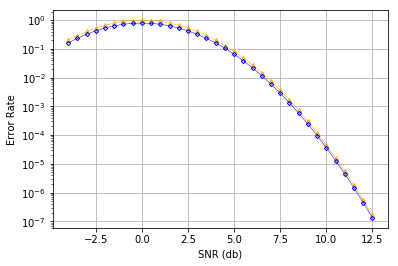

In [68]:
plt.figure()
plt.semilogy(x,y,'^-', color="orange", markerfacecolor='none', markersize=4, linewidth=0.5)
plt.semilogy(x,z,'D-', color="blue", markerfacecolor='none', markersize=3, linewidth=0.5)
plt.xlabel("SNR (db)")
plt.ylabel("Error Rate")
plt.grid()
plt.show()

### Figure 6b - RBF supervised vs unsupervised across a range of SNRs

### Rician Fading

https://en.wikipedia.org/wiki/Rician_fading
<br>

https://www.gaussianwaves.com/tag/rician/

Also see the document in downloads about it.